Procesando el dataset...
Dataset procesado: 4220 muestras.
Tamaños: Entrenamiento=3376, Validación=844
Epoch 1/50


c:\Users\danif\anaconda3\envs\ASL\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5523 - loss: 1.7214 - val_accuracy: 0.0924 - val_loss: 2.9217 - learning_rate: 0.0010
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9227 - loss: 0.2831 - val_accuracy: 0.0829 - val_loss: 2.8586 - learning_rate: 0.0010
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9613 - loss: 0.1652 - val_accuracy: 0.0829 - val_loss: 2.7666 - learning_rate: 0.0010
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9715 - loss: 0.1239 - val_accuracy: 0.1149 - val_loss: 2.4229 - learning_rate: 0.0010
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9767 - loss: 0.1053 - val_accuracy: 0.3116 - val_loss: 2.0607 - learning_rate: 0.0010
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9699 - loss: 0.1081 - val_accuracy: 0.4455 - val_loss: 1.6281 - learning_rate: 0.0010
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9782 - loss: 0.0796 - val_accuracy: 0.7263 - v

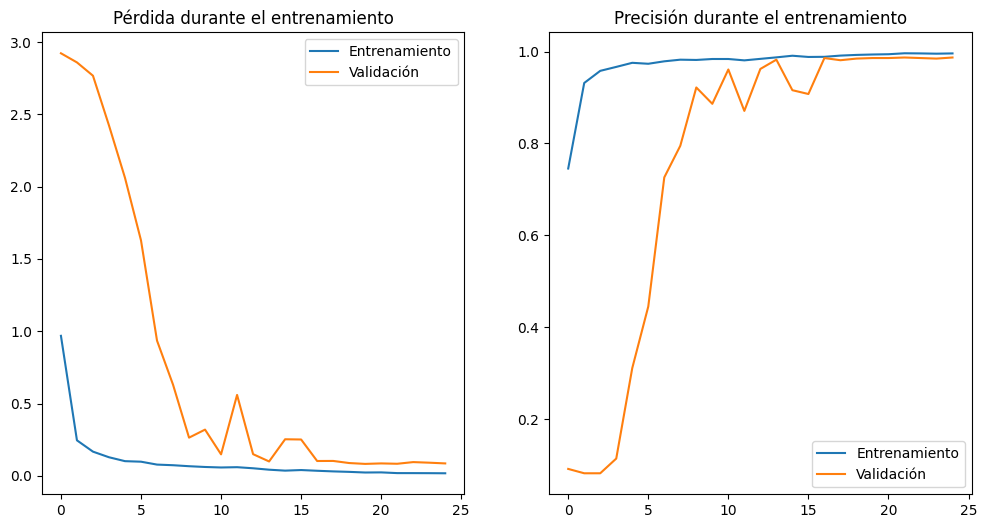

Modelo guardado como 'asl_tf_model.keras'.


In [1]:
import os
import cv2
import numpy as np
import mediapipe as mp
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Función para cargar imágenes desde una carpeta
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            images.append(img)
    return images

# Inicialización de MediaPipe para detección de manos
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1)
mp_drawing = mp.solutions.drawing_utils

# Función para extraer puntos clave de una imagen
def extract_keypoints(image):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    result = hands.process(image_rgb)
    if result.multi_hand_landmarks:
        keypoints = []
        for hand_landmarks in result.multi_hand_landmarks:
            for lm in hand_landmarks.landmark:
                keypoints.append([lm.x, lm.y, lm.z])
        return np.array(keypoints).flatten()
    return None

# Función para aumentar datos
def augment_image(image):
    augmented_images = []
    # Rotación
    rows, cols, _ = image.shape
    for angle in [-15, 15]:
        M = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)
        rotated = cv2.warpAffine(image, M, (cols, rows))
        augmented_images.append(rotated)

    # Cambio de iluminación
    for beta in [50, -50]:
        brightened = cv2.convertScaleAbs(image, alpha=1, beta=beta)
        augmented_images.append(brightened)

    return augmented_images

# Función para procesar el dataset
def process_dataset(dataset_path):
    data = []
    labels = []
    for label in os.listdir(dataset_path):
        folder = os.path.join(dataset_path, label)
        if os.path.isdir(folder):
            for img in load_images_from_folder(folder):
                keypoints = extract_keypoints(img)
                if keypoints is not None:
                    data.append(keypoints)
                    labels.append(label)

                    # Data augmentation
                    for augmented_img in augment_image(img):
                        augmented_keypoints = extract_keypoints(augmented_img)
                        if augmented_keypoints is not None:
                            data.append(augmented_keypoints)
                            labels.append(label)
    return np.array(data), np.array(labels)

# Ruta del dataset
dataset_path = "../Dataset/"

# Procesar el dataset
print("Procesando el dataset...")
X, y = process_dataset(dataset_path)
print(f"Dataset procesado: {X.shape[0]} muestras.")

# Convertir etiquetas a números
unique_labels = sorted(set(y))
label_to_num = {label: idx for idx, label in enumerate(unique_labels)}
num_to_label = {v: k for k, v in label_to_num.items()}
y_numeric = np.array([label_to_num[label] for label in y])

# Dividir datos en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y_numeric, test_size=0.2, random_state=42)

print(f"Tamaños: Entrenamiento={X_train.shape[0]}, Validación={X_val.shape[0]}")

# Crear el modelo
model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(len(unique_labels), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

# Entrenar el modelo
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr]
)

# Visualización de curvas de entrenamiento
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida durante el entrenamiento')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión durante el entrenamiento')
plt.legend()

plt.show()

# Guardar el modelo
model.save("../Models/asl_tf_model.keras")
print("Modelo guardado como 'asl_tf_model.keras'.")
